In [1]:
%matplotlib inline
import numpy as np
import pyross
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#from matplotlib import rc; rc('text', usetex=True)

## 1) Generate a trajectory
We generate a test trajectory of the SIR class on a population with two ages groups.

In [2]:
model_spec = { "classes" : ["S", "I"],

             "S" : {
                    "infection" : [ ["I","S", "-beta"] ]},  ## the I class passes infection to S class
             "I" : { "linear"    : [ ["I", "-gamma"] ],     ## this is recovery process for I class
                    "infection" : [ ["I", "S", "beta"]]}    
             
              ## the recovered class R is internally determined by number conservation
             }

beta, gamma = 0.12, 0.04

parameters = {
    'beta' : beta,
    'gamma' : gamma, 
}

M = 3                
Ni = 1000*np.ones(M)
N = np.sum(Ni) 


# Initial conditions as an array
x0 = np.array([
    999, 1000, 1000, # S
    1,   0,    0,    # I
])

# Or initial conditions as a dictionary 
I0 = [10, 10, 10]
S0 = [n-20 for n in Ni]

x0 = {
    'S' : S0,
    'I' : I0 
}

CM = np.array([
    [1,   0.5, 0.1],
    [0.5, 1,   0.5],
    [0.1, 0.5, 1  ]
], dtype=float)

def contactMatrix(t):  
    return CM

# duration of simulation and data file
Tf = 160;  Nf=Tf+1; 



In [3]:
model = pyross.stochastic.Model(model_spec, parameters, M, Ni)
# simulate model 
data = model.simulate(x0, contactMatrix, Tf, Nf)
data_array = data['X']

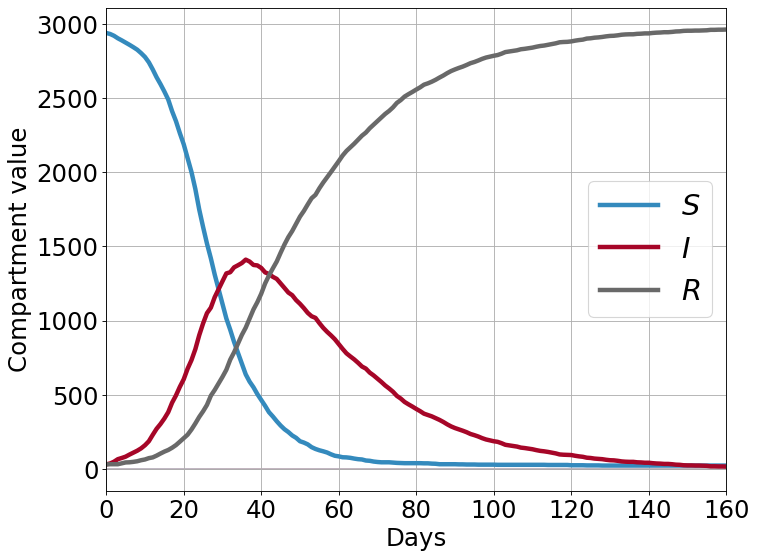

In [4]:
 # plot the data and obtain the epidemic curve
S = np.sum(model.model_class_data('S', data), axis=1)
I = np.sum(model.model_class_data('I', data), axis=1)
R = np.sum(model.model_class_data('R', data), axis=1)
t = data['t']

fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})

plt.fill_between(t, 0, S/N, color="#348ABD", alpha=0.3)
plt.plot(t, S, '-', color="#348ABD", label='$S$', lw=4)

plt.fill_between(t, 0, I/N, color='#A60628', alpha=0.3)
plt.plot(t, I, '-', color='#A60628', label='$I$', lw=4)

plt.fill_between(t, 0, R/N, color="dimgrey", alpha=0.3)
plt.plot(t, R, '-', color="dimgrey", label='$R$', lw=4)

plt.legend(fontsize=26); plt.grid() 
plt.autoscale(enable=True, axis='x', tight=True)
plt.ylabel('Compartment value')
plt.xlabel('Days');

In [5]:
# load the data and rescale to intensive variables 
Tf_inference = 20 # truncate to only getting the first few datapoints 
Nf_inference = Tf_inference+1

x = (data_array[:Nf_inference]).astype('float')

### 2) Make the Model class using model_spec

In [6]:
inference_parameters = {
    'beta' : beta, 
    'gamma' : gamma
}
 

# initialise the estimator 
estimator = pyross.inference.Model(model_spec, inference_parameters, M, Ni)

# check integrate 
logp = estimator.obtain_minus_log_p(inference_parameters, x, Tf_inference, contactMatrix)
print(logp)

261.8213473589781


In [7]:
# Define the prior (log normal prior around guess of parameter with defined std. deviation)
beta_g, gamma_g = 0.04, 0.01
beta_std, gamma_std = 0.4, 0.5

# compute -log_p for the initial guess 
guessed_parameters = {
    'beta' : beta_g, 
    'gamma' : gamma_g, 
}

logp = estimator.obtain_minus_log_p(guessed_parameters, x, Tf_inference, contactMatrix)
print(logp) 

1007.6739763159449


In [8]:
## inference 
ftol = 1e-6  # Stopping criterion for minimisation (realtive change in function value)
keys = ['beta', 'gamma']
eps = 1e-4 
param_priors = {
    'beta':{
        'mean': beta_g, 
        'std': beta_std, 
        'bounds': [eps, 0.5]
    }, 
    'gamma':{
        'mean': gamma_g, 
        'std': gamma_std, 
        'bounds': [eps, 0.6]
    }
}

estimator.set_lyapunov_method('euler')
res = estimator.infer_parameters(x, Tf_inference, contactMatrix, param_priors, 
                                    tangent=False, 
                                    global_max_iter=20, local_max_iter=200, 
                                    global_atol=1, ftol=ftol, verbose=True)

Starting global minimisation ...
         Switching to single processed mode (cma_processes = 1).
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 2 (seed=925578106, Tue Apr 19 14:04:04 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 3.609825339560775e+02 1.0e+00 1.04e+00  2e-01  2e-01 0:00.2
    2     32 3.079871459211612e+02 1.1e+00 9.93e-01  1e-01  2e-01 0:00.3
    3     48 3.540251359730925e+02 1.2e+00 9.11e-01  9e-02  2e-01 0:00.5
Global optimisation: Maximum number of iterations reached.
Optimal value (global minimisation):  261.2475851704479
Starting local minimisation...
Optimal value (local minimisation):  261.2468531072542


In [9]:
print("True parameters:")
print(inference_parameters)

print("\nInferred parameters:")
best_estimates = res['map_dict']
print(best_estimates)

True parameters:
{'beta': 0.12, 'gamma': 0.04}

Inferred parameters:
{'beta': 0.11367934132841247, 'gamma': 0.039352119019821025}


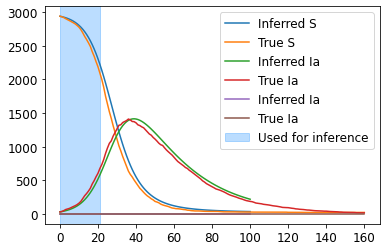

In [10]:
Nf = 101
Tf = Nf-1

estimator.set_det_model(best_estimates)
x_det = estimator.integrate(x[0], 0, Tf, Nf)
x = data['X']
plt.rcParams.update({'font.size': 12})
plt.plot(np.sum(x_det[:, :M], axis=1), label='Inferred S')
plt.plot(np.sum(x[:, :M], axis=1), label='True S')
plt.plot(np.sum(x_det[:, M:2*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, M:2*M], axis=1), label='True Ia')
plt.plot(np.sum(x_det[:, 2*M:3*M], axis=1), label='Inferred Ia')
plt.plot(np.sum(x[:, 2*M:3*M], axis=1), label='True Ia')
plt.axvspan(0, Nf_inference, 
           label='Used for inference',
           alpha=0.3, color='dodgerblue')
plt.legend()
plt.show() 